In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Loading Data, Data Cleaning

In [8]:
dfs = pd.read_excel("Interview_case_202511.xlsx", sheet_name=None)  

target_sheets = [
    "population_monthly",
    "parts_catalog",
    "vehicle_meta",
    "regions_meta"
]

dfs = {name: dfs[name] for name in target_sheets}

for name, df in dfs.items():
    print(f"---- {name} ----")
    print("Shape:", df.shape)
    print("\nMissing values per column:\n", df.isna().sum())
    print("\nColumn dtypes:\n", df.dtypes)
    print("-" * 40)

---- population_monthly ----
Shape: (11255, 14)

Missing values per column:
 date                          0
country                       0
city                          0
manufacturer                  0
vehicle_name                 10
model_name                    0
model_code                    0
engine_code                   0
displacement_l                0
fuel_type                     0
vehicle_population            0
vehicle_new_registrations     0
vehicle_retirements           0
avg_vehicle_age_years        81
dtype: int64

Column dtypes:
 date                         datetime64[ns]
country                              object
city                                 object
manufacturer                         object
vehicle_name                         object
model_name                           object
model_code                           object
engine_code                          object
displacement_l                      float64
fuel_type                            object
vehic

#### Cleaning all tables

In [9]:
for name, df in dfs.items():
    df.dropna(how="all", inplace=True) # remove empty rows/cols

    df.columns = df.columns.str.strip()     # remove whitespace from col names

    df.columns = df.columns.str.lower().str.replace(" ", "_") # standardize col names

    for col in df.select_dtypes(include=["object", "string"]): # remove any whitespace in col names
        df[col] = df[col].astype("string").str.strip()


    
    df.drop_duplicates(inplace=True) # drop duplicate rows

    dfs[name] = df

#### Cleaning population_monthly

In [10]:
pop = dfs['population_monthly']
pop = pop.convert_dtypes()
pop["date"] = pd.to_datetime(pop["date"], errors="coerce") 


pop = pop.dropna() # since na rows are <1% of dataset

pop['model_code'] = pop['model_code'].str.replace("X$", "", regex=True) # remove trailing Xs on model_codes (to match vehicle_meta's model_code) 




dfs["population_monthly"] = pop

#### Cleaning parts_catalogue

In [11]:
parts = dfs['parts_catalog']
parts = parts.convert_dtypes()

# handling nas
parts["engine_code"] = parts["engine_code"].fillna("Unknown") # impute missing engine_codes with new "unknown" category

Looking at distribution of displacement_l to determine how to deal with NAs

count       164.0
mean          1.5
std      0.675605
min           0.0
25%           1.5
50%           1.6
75%           2.0
max           2.2
Name: displacement_l, dtype: Float64


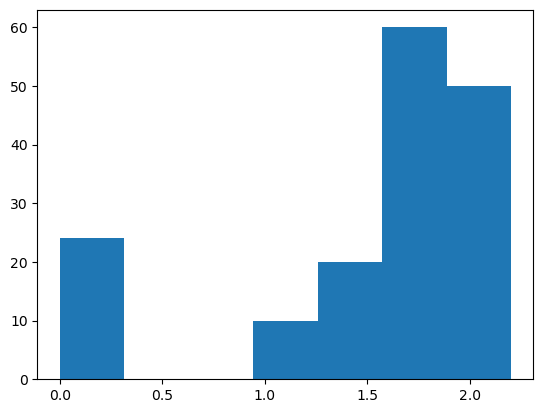

In [12]:
disp = parts["displacement_l"]
print(disp.describe())
plt.hist(disp, bins=7)
plt.show()

In [13]:
parts.groupby("fuel_type")["displacement_l"].describe()

,count,mean,std,min,25%,50%,75%,max
fuel_type,,,,,,,,
Battery Electric,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Diesel,30.0,2.0,0.287678,1.6,1.6,2.2,2.2,2.2
Gasoline,60.0,1.7,0.217848,1.5,1.5,1.6,2.0,2.0
Hybrid,50.0,1.68,0.274048,1.2,1.6,1.8,1.8,2.0


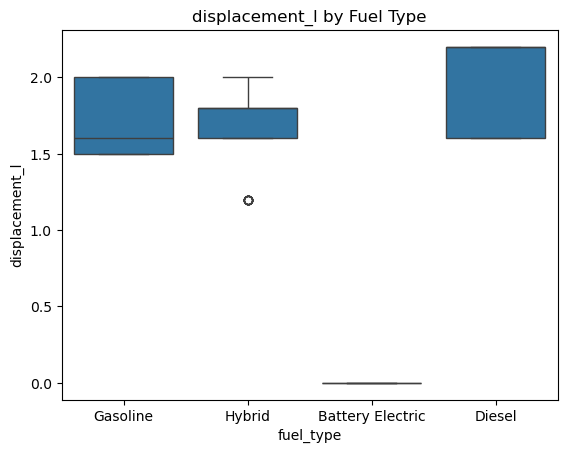

In [14]:
sns.boxplot(data=parts, x="fuel_type", y="displacement_l")
plt.title("displacement_l by Fuel Type")
plt.show()

/var/folders/2w/snn2ch354_s3_1yf6tsg1xb00000gn/T/ipykernel_57346/2834733878.py:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=parts, x="displacement_l", hue="fuel_type", fill=True, common_norm=False)


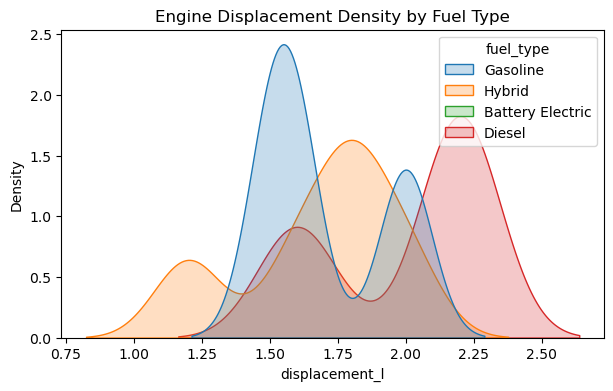

In [15]:
plt.figure(figsize=(7,4))
sns.kdeplot(data=parts, x="displacement_l", hue="fuel_type", fill=True, common_norm=False)
plt.title("Engine Displacement Density by Fuel Type")
plt.show()

In [16]:
# impute displacement_l with median witin gasoline fuel type
median_disp_gasoline = parts.loc[parts["fuel_type"] == "Gasoline", "displacement_l"].median()
parts.loc[(parts["fuel_type"] == "Gasoline") & (parts["displacement_l"].isna()), "displacement_l"] = median_disp_gasoline

/var/folders/2w/snn2ch354_s3_1yf6tsg1xb00000gn/T/ipykernel_57346/3291867064.py:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=parts, x="displacement_l", hue="fuel_type", fill=True, common_norm=False)


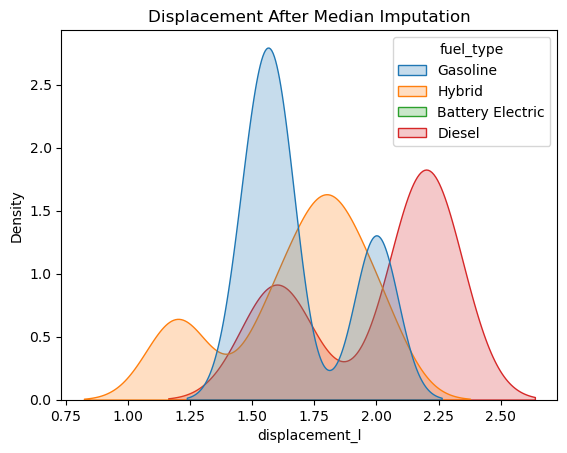

In [17]:
# check dist after imputation
sns.kdeplot(data=parts, x="displacement_l", hue="fuel_type", fill=True, common_norm=False)
plt.title("Displacement After Median Imputation")
plt.show()

Imputed missing displacement values using the median displacement within the gasoline fuel type. The gasoline displacement distribution is slightly right-skewed, so the median provides a robust estimate of the central tendency without being influenced by large-engine outliers

In [18]:
parts["displacement_l"] = pd.to_numeric(parts["displacement_l"], errors="coerce") # to be absolutely safe imputed displacement_l is numeric 

dfs["parts_catalog"] = parts

### Cleaning vehicle_meta

In [19]:
vehicle = dfs['vehicle_meta']
vehicle

,vehicle_id,manufacturer,vehicle_name,model_name,model_code,engine_code,displacement_l,fuel_type
0,JP-TY-CO15G,Toyota,Toyota Corolla,Corolla,E210,<NA>,1.5,Gasoline
1,JP-TY-CO20H,Toyota,Toyota Corolla Hybrid,Corolla,E210H,M20A-FXS,2.0,Hybrid
2,JP-TY-PR18H,Toyota,-Toyota Prius-,Prius,XW50,2ZR-FXE,1.8,Hybrid
3,JP-NS-LFBE,Nissan,Nissan Leaf,Leaf,ZE1,EM57,0.0,Battery Electric
4,JP-HN-CV15G,Honda,Honda Civic,Civic,FE,others,1.5,Gasoline
5,JP-MZ-CX52D,Mazda,Mazda CX-5,CX-5,KF,SH-VPTS,2.2,Diesel
6,JP-SB-FO20G,Subaru,Subaru Forester,Forester,SK,FB20,2.0,Gasoline
7,JP-NS-NT12H,Nissan,Nissan Note e-Power,Note,E13,HR12DE,1.2,Hybrid
8,KR-HY-AV16G,Hyundai,Hyundai Avante,Avante,CN7,Gamma II 1.6,1.6,Gasoline
9,KR-HY-SN20G,Hyundai,Hyundai Sonata,Sonata,DN8,Nu 2.0,2.0,Gasoline


In [20]:
vehicle = vehicle.convert_dtypes()

# handling nas, just NaN in engine_code; leave displacement_l as NA because in this table OT-MISC is used to categorize generically, needs to reflect real vehicle specifications
vehicle["engine_code"] = vehicle["engine_code"].fillna("Unknown")

vehicle["displacement_l"] = pd.to_numeric(vehicle["displacement_l"], errors="coerce") # to be absolutely safe imputed displacement_l is numeric 


vehicle['model_code'] = vehicle['model_code'].str.replace("X$", "", regex=True) # remove trailing Xs on model_codes (to match vehicle_meta's model_code) 


dfs['vehicle_meta'] = vehicle

### Cleaning regions_meta

In [43]:
regions = dfs['regions_meta'].copy()

dfs['regions_meta'] = dfs['regions_meta'].convert_dtypes() # just enforce python dtypes

## Check cleaned dataframes

In [22]:
for name, df in dfs.items():
    print(f"---- {name} ----")
    print("Shape:", df.shape)
    print("\nMissing values per column:\n", df.isna().sum())
    print("\nColumn dtypes:\n", df.dtypes)
    print("-" * 40)

---- population_monthly ----
Shape: (11126, 14)

Missing values per column:
 date                         0
country                      0
city                         0
manufacturer                 0
vehicle_name                 0
model_name                   0
model_code                   0
engine_code                  0
displacement_l               0
fuel_type                    0
vehicle_population           0
vehicle_new_registrations    0
vehicle_retirements          0
avg_vehicle_age_years        0
dtype: int64

Column dtypes:
 date                         datetime64[ns]
country                      string[python]
city                         string[python]
manufacturer                 string[python]
vehicle_name                 string[python]
model_name                   string[python]
model_code                   string[python]
engine_code                  string[python]
displacement_l                      Float64
fuel_type                    string[python]
vehicle_population 

## Export Cleaned Tables as CSVs

In [271]:
for name, df in dfs.items():
    df.to_csv(f"{name}_clean.csv", index=False)

## Merge Tables and Export as One CSV

In [34]:
print(pop.columns)
print(pop.head(3))
print(parts.columns)
print(parts.head(3))
print(vehicle.columns)
print(vehicle.head(3))
print(dfs['regions_meta'].columns)
print(dfs['regions_meta'].head(3))

Index(['date', 'country', 'city', 'manufacturer', 'vehicle_name', 'model_name',
       'model_code', 'engine_code', 'displacement_l', 'fuel_type',
       'vehicle_population', 'vehicle_new_registrations',
       'vehicle_retirements', 'avg_vehicle_age_years'],
      dtype='object')
        date country   city manufacturer           vehicle_name model_name  \
0 2020-01-01   Japan  Tokyo       Toyota         Toyota Corolla    Corolla   
1 2020-01-01   Japan  Tokyo       Toyota  Toyota Corolla Hybrid    Corolla   
2 2020-01-01   Japan  Tokyo       Toyota           Toyota Prius      Prius   

  model_code engine_code  displacement_l fuel_type  vehicle_population  \
0       E210     2NR-FKE             1.5  Gasoline                5516   
1      E210H    M20A-FXS             2.0    Hybrid                4919   
2       XW50     2ZR-FXE             1.8    Hybrid                5746   

   vehicle_new_registrations  vehicle_retirements  avg_vehicle_age_years  
0                          0    

In [61]:
def check_key_mismatch(left, right, keys):
    print("\n=== KEY MISMATCH CHECK ===")
    for k in keys:
        left_vals = set(left[k].unique())
        right_vals = set(right[k].unique())

        missing_in_right = left_vals - right_vals
        missing_in_left  = right_vals - left_vals
        
        print(f"\nColumn: {k}")
        print(f"  Values in LEFT not in RIGHT: {len(missing_in_right)}")
        print(f"  Values in RIGHT not in LEFT: {len(missing_in_left)}")

        if len(missing_in_right) < 20:
            print("   Examples:", list(missing_in_right))


In [58]:
def check_merge_result(df_before, df_after, right_table, right_prefix):
    print("\n=== MERGE RESULT CHECK ===")

    # A column from the right table to check
    sample_col = right_table.columns[0]  

    # After merge, the column will appear as sample_col or sample_col_suffix
    merged_col_candidates = [c for c in df_after.columns if sample_col in c]

    if not merged_col_candidates:
        print("No matching columns found — merge may have failed.")
        return
    
    merged_col = merged_col_candidates[0]

    missing = df_after[merged_col].isna().sum()
    total = len(df_after)

    print(f"Rows with NO MATCH from right table: {missing} / {total}")
    print(f"Percentage unmatched: {missing / total * 100:.2f}%")

    # show example unmatched rows
    print("\nExample unmatched rows:")
    print(df_after[df_after[merged_col].isna()].head())


In [78]:
global_keys = ["manufacturer", "model_code", "country", "city"]

def add_prefix_except(df, prefix, skip):
    return df.rename(columns={
        col: (prefix + col if col not in skip else col)
        for col in df.columns
    })

pop_pref   = add_prefix_except(pop, "pop_", global_keys)
veh_pref   = add_prefix_except(vehicle, "veh_", global_keys)
parts_pref = add_prefix_except(parts, "parts_", global_keys)
reg_pref   = add_prefix_except(regions, "reg_", global_keys)

df1 = pop_pref.merge(veh_pref, on=["manufacturer","model_code"], how="left")
df2 = df1.merge(parts_pref, on=["manufacturer","model_code"], how="left")
df_all = df2.merge(reg_pref, on=["country","city"], how="left")

In [79]:
print(df_all.shape)
print(df_all.columns.tolist())

(1274648, 43)
['pop_date', 'country', 'city', 'manufacturer', 'pop_vehicle_name', 'pop_model_name', 'model_code', 'pop_engine_code', 'pop_displacement_l', 'pop_fuel_type', 'pop_vehicle_population', 'pop_vehicle_new_registrations', 'pop_vehicle_retirements', 'pop_avg_vehicle_age_years', 'veh_vehicle_id', 'veh_vehicle_name', 'veh_model_name', 'veh_engine_code', 'veh_displacement_l', 'veh_fuel_type', 'parts_part_no', 'parts_vehicle_id', 'parts_vehicle_name', 'parts_model_name', 'parts_engine_code', 'parts_displacement_l', 'parts_fuel_type', 'parts_category', 'parts_compat_start_year', 'parts_compat_end_year', 'parts_unit_price_local', 'parts_currency', 'parts_avg_lifetime_km', 'parts_recommended_interval_km', 'parts_recommended_interval_months', 'reg_workshop_id', 'reg_workshop_name', 'reg_workshop_type', 'reg_authorized_level', 'reg_has_ev_service', 'reg_brand_focus', 'reg_max_daily_throughput_vehicles', 'reg_open_since_year']


In [80]:
df_all.to_csv("bosch_full.csv", index=False)

In [81]:
tdf = pd.read_csv("bosch_full.csv")

In [82]:
print(tdf.shape)
print(tdf.columns.tolist())

(1274648, 43)
['pop_date', 'country', 'city', 'manufacturer', 'pop_vehicle_name', 'pop_model_name', 'model_code', 'pop_engine_code', 'pop_displacement_l', 'pop_fuel_type', 'pop_vehicle_population', 'pop_vehicle_new_registrations', 'pop_vehicle_retirements', 'pop_avg_vehicle_age_years', 'veh_vehicle_id', 'veh_vehicle_name', 'veh_model_name', 'veh_engine_code', 'veh_displacement_l', 'veh_fuel_type', 'parts_part_no', 'parts_vehicle_id', 'parts_vehicle_name', 'parts_model_name', 'parts_engine_code', 'parts_displacement_l', 'parts_fuel_type', 'parts_category', 'parts_compat_start_year', 'parts_compat_end_year', 'parts_unit_price_local', 'parts_currency', 'parts_avg_lifetime_km', 'parts_recommended_interval_km', 'parts_recommended_interval_months', 'reg_workshop_id', 'reg_workshop_name', 'reg_workshop_type', 'reg_authorized_level', 'reg_has_ev_service', 'reg_brand_focus', 'reg_max_daily_throughput_vehicles', 'reg_open_since_year']
